In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pmdarima as pm



In [58]:
time_series = pd.read_csv('churn_clean_time.csv', index_col='Day', parse_dates=True)


/var/folders/5z/ygf2gykn21s37gz20p2w7pwr0000gn/T/ipykernel_94208/3081004413.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_series = pd.read_csv('churn_clean_time.csv', index_col='Day', parse_dates=True)


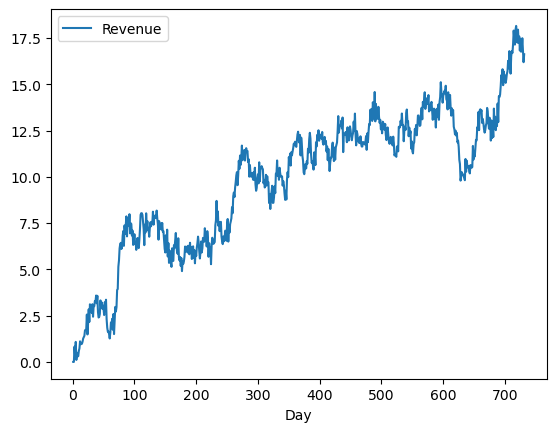

In [59]:
fig, ax1 = plt.subplots()
time_series.plot(ax=ax1)
plt.show()

In [60]:

start_date = pd.to_datetime('2023-01-01')
time_series['Date'] = start_date + pd.to_timedelta(time_series.index - 1, unit='D')



In [61]:
time_series.set_index('Date', inplace=True)
time_series = time_series.asfreq('D')



In [62]:
train = time_series.iloc[:717]
test = time_series.iloc[717:]

train.to_csv('Training Data')
test.to_csv('Test Data')


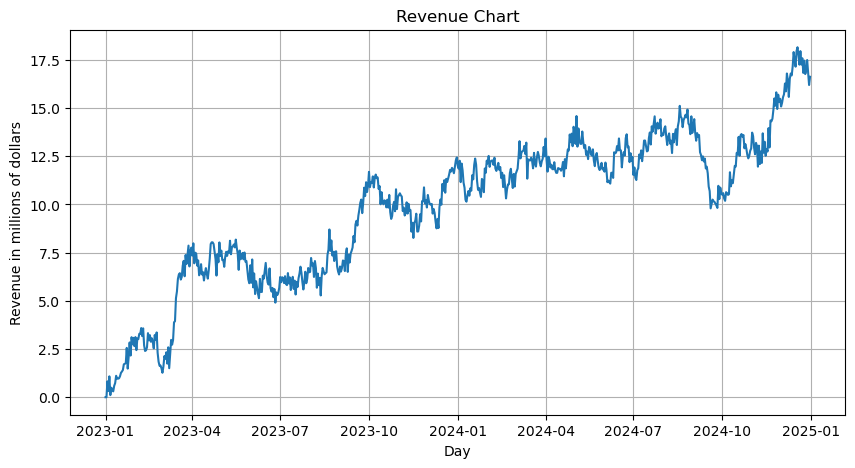

In [63]:
plt.figure(figsize=(10,5))
plt.plot(time_series['Revenue'])
plt.title('Revenue Chart')
plt.xlabel('Day')
plt.ylabel('Revenue in millions of dollars')
plt.grid(True)
plt.show()

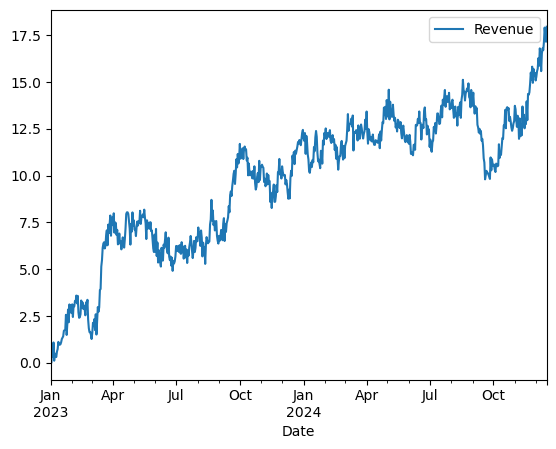

In [64]:
fig, ax1 = plt.subplots()
train.plot(ax=ax1)
plt.show()

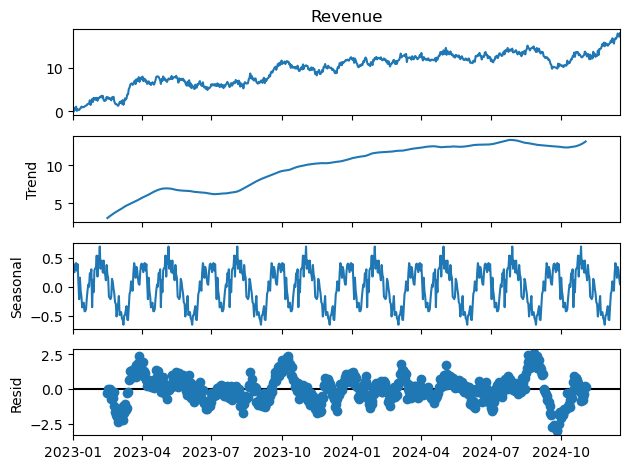

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['Revenue'], model='additive', period=90)

# Plot the components
result.plot()
plt.show()

# Access individual components if needed
trend = result.trend
seasonal = result.seasonal
residual = result.resid

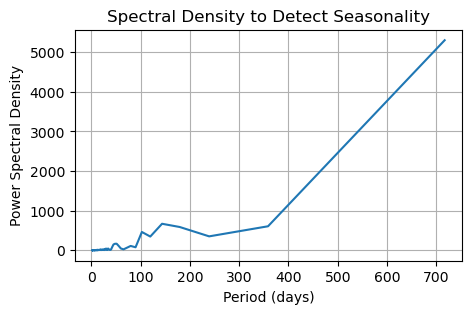

In [66]:
from scipy.signal import periodogram


data = train['Revenue'].values

# Calculate the Periodogram (estimate of power spectral density)
frequencies, power_density = periodogram(data)

# Convert frequencies to periods (e.g., days per cycle)
periods = 1 / frequencies[1:]  # Skip zero frequency to avoid division by zero
power_density = power_density[1:]

# Plot spectral density
plt.figure(figsize=(5, 3))
plt.plot(periods, power_density)
plt.xlabel('Period (days)')
plt.ylabel('Power Spectral Density')
plt.title('Spectral Density to Detect Seasonality')
plt.grid(True)
plt.show()

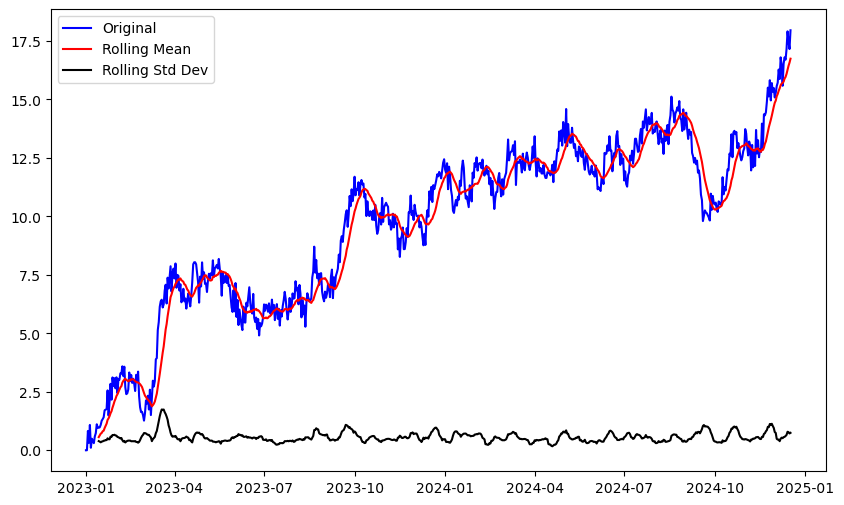

In [67]:
window_size = 14  # choose window size based on data properties

rolling_mean = train['Revenue'].rolling(window=window_size).mean()
rolling_std = train['Revenue'].rolling(window=window_size).std()

plt.figure(figsize=(10,6))
plt.plot(train['Revenue'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.legend()
plt.show()

In [68]:
#Evaluate stationarity
from statsmodels.tsa.stattools import adfuller

train_results = adfuller(train['Revenue'])

print(f"Test statistic: {train_results[0]}")
print(f"p-value: {train_results[1]}")

Test statistic: -1.6215863212530055
p-value: 0.4718977484628658


In [69]:
train_diff = train.diff().dropna()

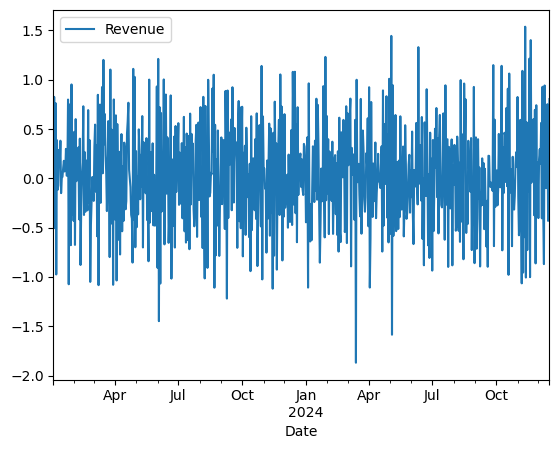

In [70]:
fig, ax1 = plt.subplots()
train_diff.plot(ax=ax1)
plt.show()

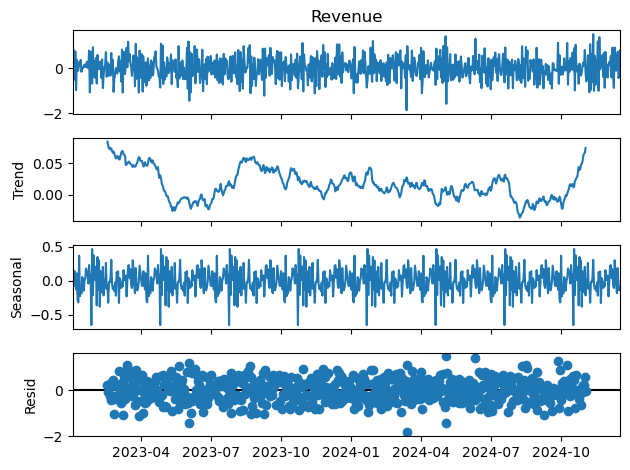

In [71]:
result_diff = seasonal_decompose(train_diff['Revenue'], model='additive', period=90)
result_diff.plot()
plt.show()



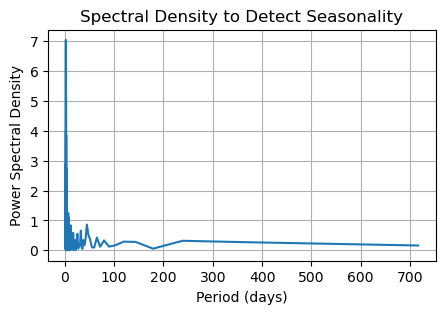

In [72]:
data_diff = train_diff['Revenue'].values

# Calculate the Periodogram (estimate of power spectral density)
frequencies, power_density = periodogram(data_diff)

# Convert frequencies to periods (e.g., days per cycle)
periods = 1 / frequencies[1:]  # Skip zero frequency to avoid division by zero
power_density = power_density[1:]

# Plot spectral density
plt.figure(figsize=(5, 3))
plt.plot(periods, power_density)
plt.xlabel('Period (days)')
plt.ylabel('Power Spectral Density')
plt.title('Spectral Density to Detect Seasonality')
plt.grid(True)
plt.show()

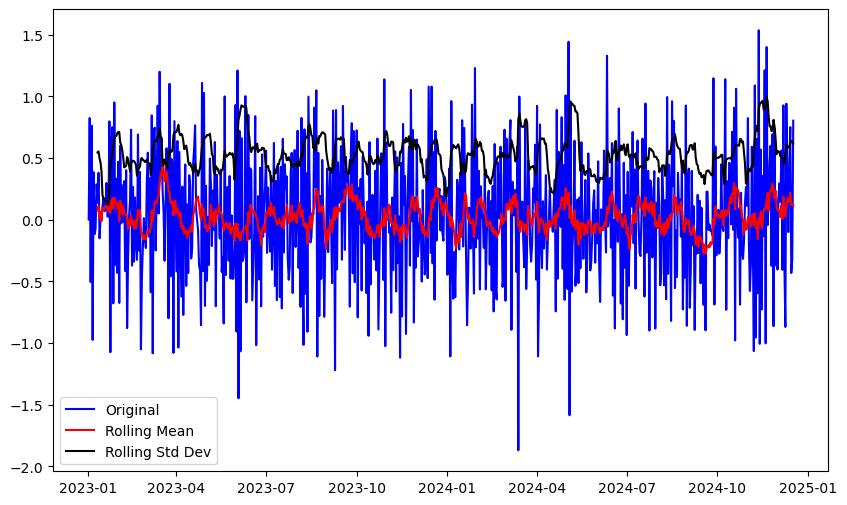

In [73]:
window_size = 10  # choose window size based on data properties

rolling_mean = train_diff['Revenue'].rolling(window=window_size).mean()
rolling_std = train_diff['Revenue'].rolling(window=window_size).std()

plt.figure(figsize=(10,6))
plt.plot(train_diff['Revenue'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.legend()
plt.show()

In [74]:
diff_results = adfuller(train_diff['Revenue'])

print(f"Test statistic: {diff_results[0]}")
print(f"p-value: {diff_results[1]}")

Test statistic: -44.41703898145712
p-value: 0.0


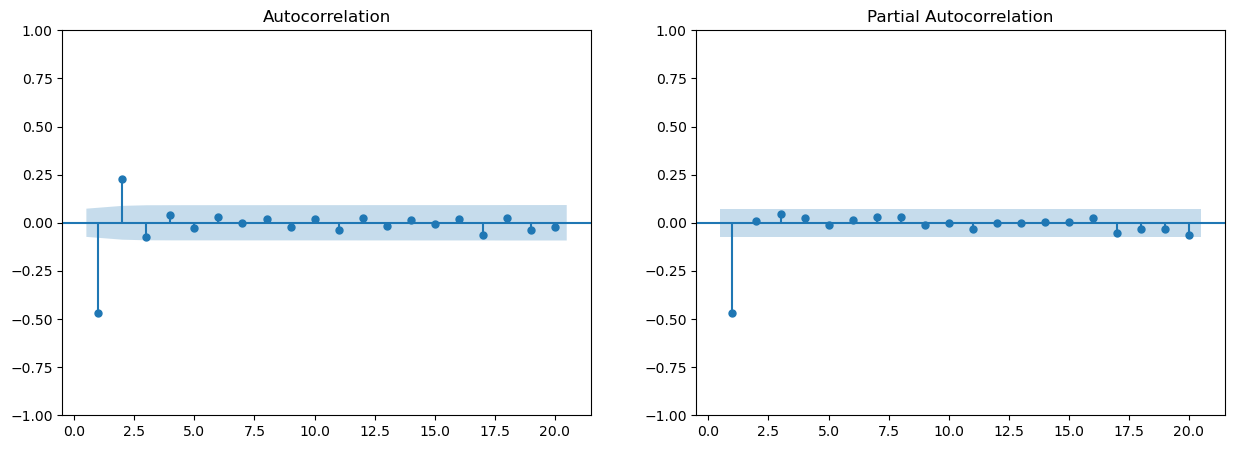

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize = (15,5))
plot_acf(train_diff, zero = False,lags=20, ax = axes[0])
plot_pacf(train_diff, zero=False, lags=20, ax=axes[1])
plt.show()

In [76]:
from statsmodels.tsa.arima.model import ARIMA
model= ARIMA(train, order=(1,1,0))
results= model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  717
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -480.454
Date:                Fri, 21 Nov 2025   AIC                            964.908
Time:                        10:42:58   BIC                            974.056
Sample:                    01-01-2023   HQIC                           968.441
                         - 12-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4668      0.033    -14.084      0.000      -0.532      -0.402
sigma2         0.2240      0.013     17.715      0.000       0.199       0.249
Ljung-Box (L1) (Q):                   0.00   Jarque-

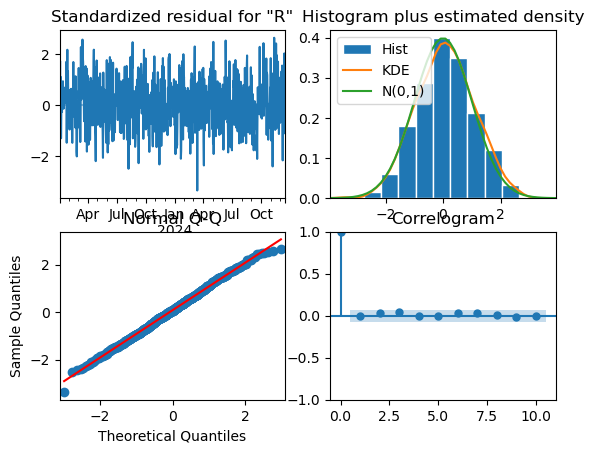

In [77]:
results.plot_diagnostics()
plt.show()

In [78]:
start = len(train)
end = len(train) + len(test) - 1

pred = results.get_prediction(start=start, end=end, dynamic=False)
pred_mean = pred.predicted_mean

pred.index= time_series.index[start:end+1]

conf_int = pred.conf_int()

In [79]:
from sklearn.metrics import root_mean_squared_error
test_mean = test['Revenue'].mean()
print(test_mean)
rmse= root_mean_squared_error(pred_mean,test['Revenue'])
print(rmse)




17.217845592142858
0.7201254632957766


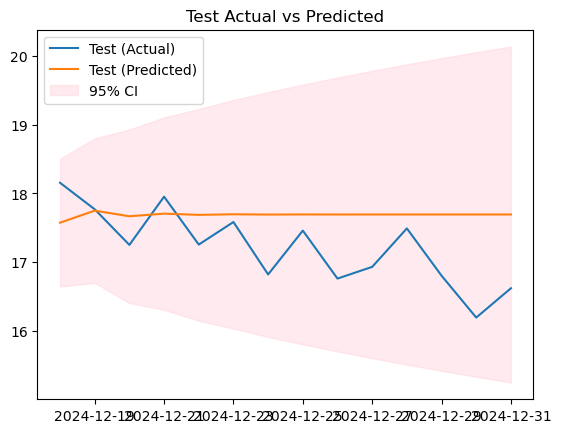

In [80]:
import matplotlib.pyplot as plt
plt.plot(test.index, test.values, label='Test (Actual)')
plt.plot(test.index, pred_mean, label='Test (Predicted)')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3, label='95% CI')
plt.legend()
plt.title('Test Actual vs Predicted')
plt.show()


In [81]:
final_model = ARIMA(time_series, order=(1,1,0))
final_results= final_model.fit()

print(final_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.355
Date:                Fri, 21 Nov 2025   AIC                            984.710
Time:                        10:43:00   BIC                            993.896
Sample:                    01-01-2023   HQIC                           988.254
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [82]:
forecast_steps = 14
forecast_obj = final_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_obj.predicted_mean
forecast_conf_int = forecast_obj.conf_int()


In [83]:
short_time_series = time_series.iloc[500:]

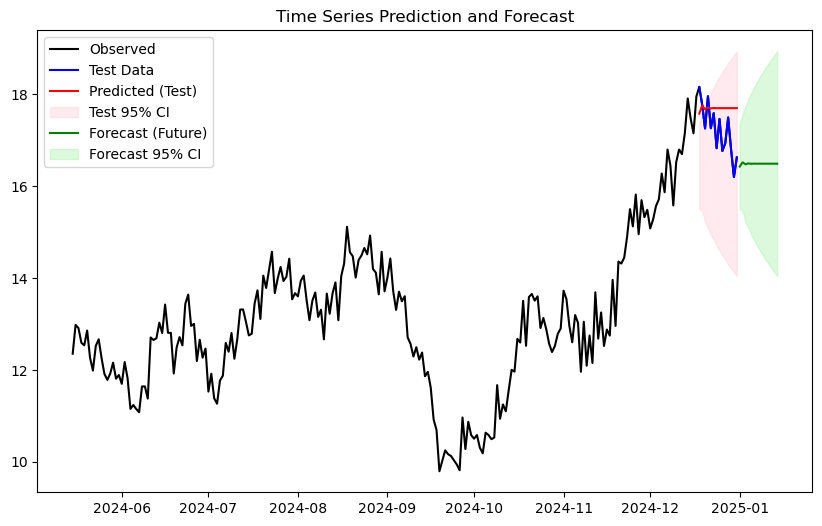

In [84]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))

# Plot observed train and test data
plt.plot(short_time_series.index, short_time_series, color='black', label='Observed')

# Highlight the test region
plt.plot(test.index, test, color='blue', label='Test Data')

# Plot predictions on the test set
plt.plot(test.index, pred_mean, color='red', label='Predicted (Test)')

# Plot confidence intervals for test predictions
plt.fill_between(test.index, forecast_conf_int.iloc[:,0], forecast_conf_int.iloc[:,1], color='pink', alpha=0.3, label='Test 95% CI')

# Plot future forecast
future_index = test.index[-1] + pd.to_timedelta(np.arange(1, forecast_steps+1), unit='D')
plt.plot(future_index, forecast_mean, color='green', label='Forecast (Future)')
plt.fill_between(future_index, forecast_conf_int.iloc[:,0], forecast_conf_int.iloc[:,1], color='lightgreen', alpha=0.3, label='Forecast 95% CI')

plt.legend()
plt.title('Time Series Prediction and Forecast')
plt.show()
